# Advanced Guide to Model Building in Mantisshrimp


## Goal

In this book, we will show how to:

- Create a custom Parser: we are using the Wheat example for the [Kaggle Global Wheat Competition](https://www.kaggle.com/c/global-wheat-detection)
- Train the model using Fastai library
- Train the model using Pytorch-Lightning library
- Use a custom backbone
- Save a trained model
- Make predictions using our Inference API

## Install
- Simple have Pytorch and get this from GitHub (release on PyPi to be soon)

```
pip install -r requirements.txt
pip install git+git://github.com/lgvaz/mantisshrimp.git
```

In [1]:
!pip install -q 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [2]:
!pip install -q fastai2

In [3]:
!pip install -q pytorch_lightning

In [4]:
! pip -q install git+git://github.com/lgvaz/mantisshrimp.git

## Getting started


### Imports

Mantisshrimp is built in such a way that is safe to use wildcard imports, .e.g. ```from mantisshrimp import *.```

```from mantisshrimp.imports import * ``` will import commonly used packages like np and plt.

``` from mantisshrimp import * ``` will import all mantis modules needed for development.


In [5]:
from mantisshrimp.imports import *
from mantisshrimp import *
import pandas as pd
import albumentations as A

## Loading the data
-  The first step is to understand the data. In this task we were given a .csv file with annotations, let's take a look at that.

- Note:

- Replace source with your own path for the dataset directory.


## Parser

- To process the data into format feedable to the models we need to create a parser.


In [6]:
path = Path('../input/global-wheat-detection/')
df = pd.read_csv(path / "train.csv")
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


At first glance, we can make the following assumptions:

-    Multiple rows with the same object_id, width, height
-    A different bbox for each row
-    source doesn't seem relevant right now

- Once we know what our data provides we can create our custom Parser.

- When creating a Parser we inherit from smaller building blocks that provides the functionallity we want:

-    DefaultImageInfoParser: Will parse standard fields for image information, e.g. filepath, height, width
-    FasterRCNNParser: Since we only need to predict bboxes we will use a FasterRCNN model, this will parse all the requirements for using such a model.

We can also specify exactly what fields we would like to parse, in fact, the parsers we are currently using are just helper classes that groups a collection of individual parsers.

We are going to see how to use individual parsers in a future tutorial.




Defining the __init__ is completely up to you, normally we have to pass our data (the df in our case) and the folder where our images are contained (source in our case).

We then override __iter__, telling our parser how to iterate over our data. In our case we call df.itertuples to iterate over all df rows.

__len__ is not obligatory but will help visualizing the progress when parsing.

And finally we override all the other methods, they all receive a single argument o, which is the object returned by __iter__.

Now we just need to decide how to split our data and Parser.parse!


In [7]:
class WheatParser(DefaultImageInfoParser, FasterRCNNParser):
    def __init__(self, df, source):
        self.df = df
        self.source = source
        self.imageid_map = IDMap()

    def __iter__(self):
        yield from self.df.itertuples()

    def __len__(self):
        return len(self.df)

    def imageid(self, o) -> int:
        return self.imageid_map[o.image_id]

    def filepath(self, o) -> Union[str, Path]:
        return self.source / f"{o.image_id}.jpg"

    def height(self, o) -> int:
        return o.height

    def width(self, o) -> int:
        return o.width

    def labels(self, o) -> List[int]:
        return [1]

    def bboxes(self, o) -> List[BBox]:
        return [BBox.from_xywh(*np.fromstring(o.bbox[1:-1], sep=","))]

## Mantisshrimp now simplifes the boiler plate for you :-)

- It creates a RandomSpitter which divides data into trainand test.
- Then we create the parser and simply parse the data

In [8]:
data_splitter = RandomSplitter([.8, .2])
parser = WheatParser(df, source / "train")
train_rs, valid_rs = parser.parse(data_splitter)

Let's take a look at one record.

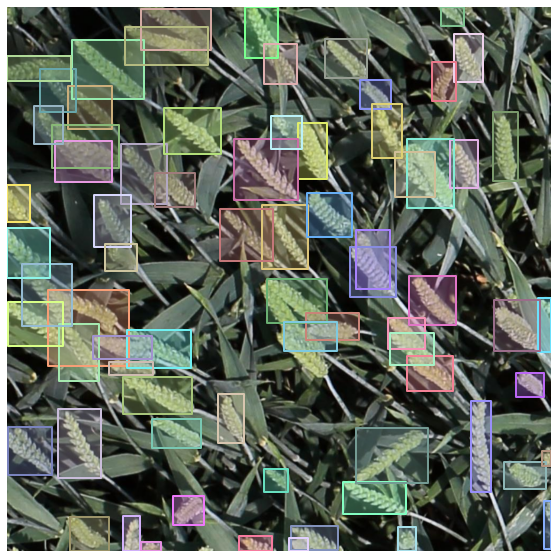

In [9]:
show_record(train_rs[0], label=False)

## Transforms

Mantisshrimp is agnostic to the transform library you want to use. We provide default support for albumentations but if you want to use another library you just need to inherit and override all abstract methods of Transform.

For simplicity, let's use a single transform on the train data and no transforms on the validation data.


In [10]:
train_tfm = AlbuTransform([A.Flip()])

## Datasets


- This is equivalent to PyTorch datasets that we use always.
- For creating a Dataset we just need need to pass the parsed records from the previous step and optionally a transform.

In [11]:
train_ds = Dataset(train_rs, train_tfm)
valid_ds = Dataset(valid_rs)


## Model


- It uses the torchvision implementation of Faster RCNN which most people are using here.
- Best part, we can try Faster RCNN with multiple Backbones, and its hardly any line of code.
- It allows flexible model implementation coz we don't want to limit the library

In [12]:
from mantisshrimp.models.rcnn.faster_rcnn import *
from mantisshrimp.models.rcnn import *

In [13]:
# Using the FasterRCNN Basic Model with resnet50 fpn backbone
model = faster_rcnn.model(num_classes=2)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


## Backbones

- [Backbones](https://github.com/lgvaz/mantisshrimp/tree/master/mantisshrimp/backbones) define which CNN is being used as feature extractor or base of the model.
- Mantisshrimp supports all torchvision CNN models as well models from PyTorch Image models by ross wightman.

In [14]:
from mantisshrimp import backbones

- It supports many resnet models with fpn on top of it.
- You can use pretrained imagenet Backbones as well.

- Is supports [backbones](https://github.com/lgvaz/mantisshrimp/tree/master/mantisshrimp/backbones) "resnet18", "resnet34","resnet50", "resnet101", "resnet152", "resnext50_32x4d", "resnext101_32x8d", "wide_resnet50_2", "wide_resnet101_2", as resnets with fpn backbones.

In [15]:
resnet_101_backbone = backbones.resnet_fpn.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [16]:
resnet_152_backbone = backbones.resnet_fpn.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


- It supports backbones "resnet18", "resnet34", "resnet50","resnet101", "resnet152", "resnext101_32x8d", "mobilenet", "vgg11", "vgg13", "vgg16", "vgg19", without fpn networks

In [17]:
vgg11_backbone = backbones.vgg.vgg11(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/checkpoints/vgg11-bbd30ac9.pth


## Mantisshrimp Engines

- Now engine enters the picture.

- We provide out of box support to train with Fastai and PyTorch Lightning.

- You can use any one, at end of the day both remain PyTorch models.

## Train Using Fastai

- We provide support for COCO Metrics too, very useful while training

In [ ]:
# metrics = []
# metrics += [COCOMetric(valid_rs, bbox=True, mask=False, keypoint=False)]

## DataLoader

- Another feature is that all mantis models have a `dataloader` method that returns a customized `DataLoader` for each model.

In [25]:
train_dl = faster_rcnn.dataloaders.train_dataloader(train_ds, batch_size=4, num_workers=4, shuffle=True)
valid_dl = faster_rcnn.dataloaders.valid_dataloader(valid_ds, batch_size=4, num_workers=4, shuffle=False)

In [27]:
# This creates the default model with resnet50 fpn backbone
# model = faster_rcnn.model(num_classes=2)

# To create model with backbones 
model = faster_rcnn.model(num_classes=2, backbone=resnet_152_backbone)

In [28]:
learner = faster_rcnn.fastai.learner([train_dl, valid_dl], model)

/opt/conda/lib/python3.7/site-packages/fastai2/callback/core.py:29: UserWarning: You are setting an attribute (loss) that also exists in the learner. Please be advised that you're not setting it in the learner but in the callback. Use `self.learn.loss` if you would like to change it in the learner.
  warn(f"You are setting an attribute ({name}) that also exists in the learner. Please be advised that you're not setting it in the learner but in the callback. Use `self.learn.{name}` if you would like to change it in the learner.")


In [29]:
learner.fine_tune(2, lr=1e-4)

epoch,train_loss,valid_loss,time
0,1.262132,1.240003,10:35


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


epoch,train_loss,valid_loss,time
0,0.682398,0.660053,18:55
1,0.576909,0.555283,18:53


## Train using PyTorch Lightning

In [20]:
class LightModel(faster_rcnn.lightning.ModelAdapter):
    def configure_optimizers(self):
        opt = SGD(self.parameters(), 2e-4, momentum=0.9)
        return opt


In [21]:
model = faster_rcnn.model(num_classes=2, backbone=resnet_152_backbone)

In [22]:
light_model = LightModel(model=model) #metrics=metrics)

In [23]:
from pytorch_lightning import Trainer

In [24]:
trainer = Trainer(max_epochs=2, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 75 M  


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


1

## Saving the Model

In [25]:
# Save the model as same as you would do for a Pytorch model
# You can also use lightning features to even automate this.

torch.save(light_model.state_dict(), "mantiss_faster_rcnn.pt")

## Making Predictions

In [26]:
detection_threshold = 0.45

In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [28]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for s, b in zip(scores, boxes.astype(int)):
        pred_strings.append(f'{s:.4f} {b[0]} {b[1]} {b[2] - b[0]} {b[3] - b[1]}')

    return " ".join(pred_strings)

In [1]:
# Just using the Fastai model for now. You can replace this with Light model as well.
model.eval()
model.to(device)

In [30]:
detection_threshold = 1e-8
results = []
device = 'cuda'
for images in os.listdir("../input/global-wheat-detection/test/"):
    image_path = os.path.join("../input/global-wheat-detection/test/", images)
    image = cv2.imread(image_path)
    image = np.transpose(image, (2, 0, 1))
    image = image / 255.
    image = torch.tensor(image, dtype=torch.float)
    image = torch.unsqueeze(image, 0)
    image = image.to(device)
    model
#     print(image.shape)
    with torch.no_grad():
        outputs = model(image)
    
#     print(outputs)

    boxes = outputs[0]['boxes'].data.cpu().numpy()
    scores = outputs[0]['scores'].data.cpu().numpy()

    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    scores = scores[scores >= detection_threshold]
    image_id = images[:-3]

    result = {
        'image_id': image_id,
        'PredictionString': format_prediction_string(boxes, scores)
    }

    results.append(result)
#     break


In [31]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,796707dd7.,0.9835 892 326 108 95 0.9809 702 824 111 105 0.9749 499 780 102 102 0.9732 0 445 68 90 0.9714 349 0 83 61 0.9678 939 66 82 111 0.9501 134 545 138 110 0.9491 675 709 82 100 0.9306 611 34 100 83 0.9283 103 792 100 88 0.9190 44 89 170 106 0.9069 249 474 93 106 0.9055 674 27 126 129 0.8951 680 448 101 154 0.8831 374 621 99 140 0.8831 461 269 122 103 0.8787 220 835 122 82 0.8770 426 185 83 89 0.8714 246 322 82 161 0.8611 301 275 88 125 0.8575 663 559 122 151 0.8444 801 530 135 154 0.8337 235 0 113 47 0.8137 388 619 82 79 0.7730 214 675 91 82 0.6770 194 471 81 77 0.6689 592 490 79 77 0.6685 59 5...
1,cc3532ff6.,0.9866 369 0 97 106 0.9841 911 125 106 92 0.9761 606 423 94 106 0.9742 489 568 100 149 0.9719 258 631 107 179 0.9694 689 471 151 93 0.9693 470 395 124 162 0.9675 716 294 118 95 0.9632 552 826 96 100 0.9520 33 342 98 73 0.9487 306 286 92 87 0.9417 96 609 86 151 0.9375 401 206 87 88 0.9368 755 829 182 176 0.9332 0 418 164 99 0.9327 779 696 111 108 0.9302 72 816 138 162 0.9267 952 1 72 86 0.9106 564 299 104 112 0.8850 769 2 101 128 0.8816 14 657 104 71 0.7850 6 475 73 78 0.7729 26 644 173 87 0.7387 10 363 133 179 0.7025 583 889 103 112 0.6457 0 769 43 71 0.6198 291 839 101 66 0.5801 10 404 84...
2,51f1be19e.,0.9569 18 0 99 68 0.9546 274 464 155 134 0.9402 765 886 140 100 0.9393 636 793 111 76 0.9368 194 917 107 101 0.9321 688 914 98 84 0.9262 835 338 136 119 0.9229 600 95 153 166 0.9224 811 84 108 75 0.9153 815 757 91 86 0.9068 325 141 142 138 0.8867 902 693 105 82 0.8552 669 595 104 84 0.8491 240 117 88 119 0.8478 492 487 111 85 0.8331 860 271 104 204 0.8250 69 692 91 84 0.8121 563 588 113 128 0.7668 485 477 202 92 0.7495 0 379 49 106 0.6596 527 970 91 54 0.6227 534 462 178 89 0.5940 46 520 70 80 0.5751 659 428 83 72 0.5720 775 24 102 65 0.5616 74 684 82 165 0.5557 850 276 117 104 0.4984 120 ...
3,51b3e36ab.,0.9824 361 151 110 106 0.9809 471 577 88 85 0.9798 499 190 102 81 0.9786 0 901 86 121 0.9712 231 635 98 180 0.9694 420 925 88 99 0.9683 12 823 90 98 0.9578 440 323 150 97 0.9573 856 711 82 81 0.9540 377 424 108 82 0.9531 874 185 131 80 0.9519 462 4 87 164 0.9514 873 287 151 136 0.9464 329 466 91 152 0.9425 600 762 171 115 0.9412 113 848 143 90 0.9127 755 817 208 122 0.9046 534 29 271 129 0.8943 503 394 120 93 0.8894 11 435 82 213 0.8806 822 455 199 155 0.8713 609 374 174 95 0.8594 6 0 79 172 0.7965 7 580 87 188 0.7126 707 670 157 80 0.6970 1 412 103 365 0.5088 448 320 173 162 0.4831 553 24...
4,f5a1f0358.,0.9833 543 401 84 96 0.9782 683 197 122 101 0.9779 411 168 68 74 0.9767 63 457 136 119 0.9727 258 657 95 82 0.9725 659 104 88 92 0.9723 596 723 109 93 0.9701 224 317 124 99 0.9700 815 404 100 99 0.9684 1 831 65 131 0.9676 297 455 155 103 0.9672 881 628 97 168 0.9626 153 243 69 83 0.9616 149 758 163 123 0.9600 126 612 72 79 0.9447 224 558 80 92 0.9405 299 568 76 80 0.9387 2 5 64 66 0.9322 541 277 108 113 0.9281 692 564 85 135 0.9183 527 0 110 105 0.9134 405 677 84 123 0.9094 949 440 75 192 0.8918 87 818 67 75 0.8481 470 796 135 87 0.8111 459 314 85 156 0.6798 783 578 86 97 0.5494 459 575 56...
